In [ ]:
!pip install torch
!pip install transformers
!pip install accelerate -U
!pip install tqdm
!pip install pytorch-crf
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00


In [ ]:
import os
os.makedirs("./runs/exp_seed_117", exist_ok=True)
os.makedirs("./runs/exp_seed_117/logs", exist_ok=True)
#os.makedirs("./runs/exp_seed_117/allenai-longformer-base-4096-p", exist_ok=True)
os.makedirs("./runs/exp_seed_117/debertav3base", exist_ok=True)

In [ ]:
import torch
import json
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers.trainer_callback import TrainerState
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import transformers
from torch import nn
from transformers import AutoModel, AutoConfig
from torchcrf import CRF
from torch.cuda.amp import autocast
from transformers import Trainer
from tqdm import tqdm
import pandas as pd
import numpy as np
import logging
import glob
from tqdm import tqdm
from dataclasses import dataclass, field
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
@dataclass
class ModelConfig:
    model_path = "microsoft/deberta-v3-base"
    #model_path = "allenai/longformer-base-4096-extra.pos.embd.only"
    #model_checkpoint_dir = "./runs/exp_200/allenai-longformer-base-4096-p"
    model_checkpoint_dir = "./runs/exp_117/microsoft-deberta-v3-base"
@dataclass
class DatasetConfig:
    train_file = "/content/drive/MyDrive/SemEval 2024/subtaskC_train.jsonl"
    #dev_file = "/content/drive/MyDrive/SemEval 2024/subtaskC_dev.jsonl"
    test_files = ["/content/drive/MyDrive/SemEval 2024/subtaskC_dev.jsonl"]
@dataclass
class TrainingArgsConfig:
    do_train = True
    do_predict = False
    seed = 117
    output_dir = "./runs/exp_seed_117"
    logging_steps = 160
    logging_dir = "./runs/exp_seed_117/logs"
    num_train_epochs = 30
    per_device_train_batch_size = 4
    per_device_eval_batch_size = 4
    max_length = 1024
model_args = ModelConfig()
data_args = DatasetConfig()
training_args = TrainingArgsConfig()
class CRFTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def compute_loss(self, model, inputs, return_outputs=False):
        print(inputs.keys())
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        emissions = outputs[0]
        mask = inputs["attention_mask"]
        crf_loss = -model.crf(emissions, labels, mask=mask)
        return crf_loss
    def training_step(self, model, inputs):
        loss = self.compute_loss(model, inputs)
        return {"loss": loss, "inputs": inputs}
class AutoModelCRF(nn.Module):
  ##########################################################
    def __init__(self, model_name_or_path, dropout=0.075):
        super(AutoModelCRF, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name_or_path)
        self.num_labels = 2
        self.encoder = AutoModel.from_pretrained(model_name_or_path, trust_remote_code=True, config=self.config)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.config.hidden_size, self.num_labels)
        self.crf = CRF(self.num_labels, batch_first=True)
    def forward(self, input_ids, attention_mask, labels=None):
        inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
        outputs = self.encoder(**inputs)
        seq_output = outputs[0]
        seq_output = self.dropout(seq_output)
        emission = self.linear(seq_output)
        if labels is None:
            tags = self.crf.decode(emission, attention_mask.byte())
            tags_padded = []
            for idx, sequence in enumerate(tags):
                if len(attention_mask[idx]) > len(sequence):
                    tag_padded = sequence + [sequence[-1]]*(len(attention_mask[idx])-len(sequence))
                else:
                    tag_padded = sequence
                tags_padded.append(tag_padded)
            out = np.array(tags_padded)
            return out
        else:
            crf_loss = -self.crf(emission, labels, mask=attention_mask.byte())
            return crf_loss
def evaluate_position_difference(actual_position, predicted_position):
    return abs(actual_position - predicted_position)
#def get_start_position(sequence, mapping=None, token_level=True):
#    if mapping is not None:
#        mask = mapping != -100
#        sequence = sequence[mask]
#        mapping = mapping[mask]
#    index = np.where(sequence == 1)[0]
#    value = index[0] if index.size else (len(sequence) - 1)
#    if not token_level:
#        value = mapping[value]
#    return value
def get_start_position(sequence, mapping=None, token_level=True):
    if mapping is not None:
        mask = mapping != -100
        sequence = sequence[mask]
        mapping = mapping[mask]
    change_indices = np.where(np.diff(sequence) == 1)[0]
    if len(change_indices) > 0:
        value = change_indices[0] + 1
    else:
        value = 0 if sequence[0] == 1 else len(sequence) - 1
    if not token_level:
        value = mapping[value] if mapping is not None else value
    return value
def evaluate_machine_start_position(labels, predictions, idx2word=None, token_level=False):
    actual_starts = []
    predicted_starts = []
    if not token_level and idx2word is None:
        raise ValueError("idx2word must be provided if evaluation is at word level (token_level=False)")
    for idx in range(labels.shape[0]):
        # ?
        predict, label, mapping = (predictions[idx][1:len(labels[idx])], labels[idx][1:len(labels[idx])], idx2word[idx][1:len(labels[idx])] if not token_level else None,)
        predicted_value = get_start_position(predict, mapping, token_level)
        actual_value = get_start_position(label, mapping, token_level)
        predicted_starts.append(predicted_value)
        actual_starts.append(actual_value)
    position_differences = [ evaluate_position_difference(actual, predict) for actual, predict in zip(actual_starts, predicted_starts) ]
    mean_position_difference = np.mean(position_differences)
    return mean_position_difference
def compute_metrics(p):
    pred, labels = p
    mean_absolute_diff = evaluate_machine_start_position(labels, pred, token_level=True)
    return {"mean_absolute_diff": mean_absolute_diff,}
def training_loop(model, optimizer, train_dataloader, device):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask, labels=labels)
        loss.backward()
        optimizer.step()
        logger.info(f"Step {step}: {loss.item():.4f}")
        total_loss += loss.item()
    avg_loss = total_loss/len(train_dataloader)
    print(f"Training loss: {avg_loss:.4f}")
#def validation_loop(model, val_dataloader, device):
#    model.eval()
#    all_preds = []
#    all_labels = []
#    with torch.no_grad():
#        for step, batch in enumerate(tqdm(val_dataloader)):
#            input_ids = batch["input_ids"].to(device)
#            attention_mask = batch["attention_mask"].to(device)
#            labels = batch["labels"].to(device)
#            preds = model(input_ids, attention_mask)
#            all_preds.extend(preds)
#            all_labels.extend(labels.detach().cpu().numpy())
#    diff_loss = compute_metrics((np.array(all_preds), np.array(all_labels)))
#    return diff_loss["mean_absolute_diff"]
def predict(model, test_dataloader, device):
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            preds = model(input_ids, attention_mask)
            all_preds.extend(preds)
    out = np.array(all_preds)
    print(out.shape)
    return out
def save_model(model_name, model, optimizer, epoch, output_dir): # train_mae, val_mae,
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()} # 'train_mae': train_mae,'val_mae': val_mae,
    model_name = model_name.replace("/", "-")
    file_path = os.path.join(output_dir, f"{model_name}-epoch-{epoch}.pt")
    print(file_path)
    torch.save(checkpoint, file_path)
    logger.info(f"Model has been saved successfully to {file_path}")
def load_best_checkpoint(checkpoints_dir: str):
    ckp_paths = glob.glob(os.path.join(checkpoints_dir, "*.pt"))
    min_mae = 1000000
    best_ckp = ""
    for ckp_path in tqdm(ckp_paths):
        checkpoint_info = torch.load(ckp_path)
        if checkpoint_info['val_mae'] < min_mae:
            best_ckp = ckp_path
            print(f"Best checkpoint: {best_ckp}")
            min_mae = checkpoint_info['val_mae']
    logger.info(f"best checkpoint: {best_ckp}")
    return best_ckp
class Semeval_Data(torch.utils.data.Dataset):
  ############################ 1024 len real
    def __init__(self, data_path, model_name, max_length=512, inference=False, debug=False):
        with open(data_path, "r") as f:
            self.data = [json.loads(line) for line in f]
        self.inference = inference
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_length = max_length
        self.debug = debug
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        id = self.data[idx]["id"]
        label = None
        labels_available = "label" in self.data[idx]
        if labels_available:
            label = self.data[idx]["label"]
        if self.debug and not self.inference:
            print("Orignal Human Position: ", label)
        labels = []
        corresponding_word = []
        tokens = []
        input_ids = []
        attention_mask = []
        for jdx, word in enumerate(text.split(" ")):
            word_encoded = self.tokenizer.tokenize(word)
            sub_words = len(word_encoded)
            if labels_available:
                is_machine_text = 1 if jdx >= label else 0
                labels.extend([is_machine_text] * sub_words)
            corresponding_word.extend([jdx] * sub_words)
            tokens.extend(word_encoded)
            input_ids.extend(self.tokenizer.convert_tokens_to_ids(word_encoded))
            attention_mask.extend([1] * sub_words)
        if len(input_ids) < self.max_length - 2:
            input_ids = ( [0] + input_ids + [2] + [1] * (self.max_length - len(input_ids) - 2) )
            if labels_available:
                labels = [0] + labels + [labels[-1]] * (self.max_length - len(labels) - 1)
            attention_mask = ( [1] + attention_mask + [1] + [0] * (self.max_length - len(attention_mask) - 2) )
            corresponding_word = ( [-100] + corresponding_word + [-100] * (self.max_length - len(corresponding_word) - 1) )
            tokens = ( ["<s>"] + tokens + ["</s>"] + ["<pad>"] * (self.max_length - len(tokens) - 2) )
        else:
            input_ids = [0] + input_ids[: self.max_length - 2] + [2]
            if labels_available:
                labels = [0] + labels[: self.max_length - 2] + [labels[self.max_length - 3]]
            corresponding_word = ( [-100] + corresponding_word[: self.max_length - 2] + [-100] )
            attention_mask = [1] + attention_mask[: self.max_length - 2] + [1]
            tokens = ["<s>"] + tokens[: self.max_length - 2] + ["</s>"]
        encoded = {}
        if labels_available:
            encoded["labels"] = torch.tensor(labels)
        encoded["input_ids"] = torch.tensor(input_ids)
        encoded["attention_mask"] = torch.tensor(attention_mask)
        if labels_available:
            if encoded["input_ids"].shape != encoded["labels"].shape:
                print("Input IDs Shape: ", encoded["input_ids"].shape)
                print("Labels Shape: ", encoded["labels"].shape)
            assert encoded["input_ids"].shape == encoded["labels"].shape
        if self.debug and not self.inference:
            print("Tokenized Human Position: ", labels.index(1))
            print("Original Human Position: ", label)
            print("Full Human Text:", text)
            print("\n")
            print("Human Text Truncated:", text.split(" ")[:label])
            print("\n")
            encoded["partial_human_review"] = " ".join(text.split(" ")[:label])
        if self.inference:
            encoded["text"] = text
            encoded["id"] = id
            encoded["corresponding_word"] = corresponding_word
        return encoded
if __name__ == "__main__":
    model_args = ModelConfig()
    data_args = DatasetConfig()
    training_args = TrainingArgsConfig()
    print("Model Arguments: ", model_args)
    print("Data Arguments: ", data_args)
    print("Training Arguments: ", training_args)
    transformers.set_seed(training_args.seed)
    model_path = model_args.model_path
    model_checkpoint_dir = model_args.model_checkpoint_dir
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelCRF(model_path).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    train_set = Semeval_Data(data_args.train_file, model_path, max_length=training_args.max_length)
    #dev_set = Semeval_Data(data_args.dev_file, model_path, max_length=training_args.max_length)
    train_dataloader = DataLoader(train_set, batch_size=training_args.per_device_train_batch_size, shuffle=True)
    #dev_dataloader = DataLoader(dev_set, batch_size=training_args.per_device_eval_batch_size, shuffle=False)
    train_eval_dataloader = DataLoader(train_set, batch_size=training_args.per_device_eval_batch_size, shuffle=False)
    if training_args.do_train:
        logger.info("Training...")
        logger.info("*** Train Dataset ***")
        logger.info(f"Number of samples: {len(train_set)}")
        #logger.info("*** Dev Dataset ***")
        #logger.info(f"Number of samples: {len(dev_set)}")
        num_train_epochs = training_args.num_train_epochs
        for epoch in tqdm(range(num_train_epochs)):
            training_loop(model, optimizer, train_dataloader, device)
            #train_mse = validation_loop(model, train_dataloader, device)
            #val_mse = validation_loop(model, dev_dataloader, device)
            #logger.info(f"Validation MSE: {val_mse:.4f}, Training MSE: {train_mse:.4f}")
            save_model(model_path, model, optimizer, epoch, model_checkpoint_dir) # ,train_mse ,val_mse
        logger.info("Training completed!")
    if training_args.do_predict:
        test_sets = []
        checkpoint = load_best_checkpoint(model_checkpoint_dir)
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        for test_file in data_args.test_files:
            test_set = Semeval_Data(test_file, model_path, max_length=training_args.max_length, inference=True)
            test_set = DataLoader(test_set, batch_size=training_args.per_device_eval_batch_size, shuffle=False)
            test_sets.append(test_set)
        logger.info("Predicting...")
        logger.info("*** Test Datasets ***")
        logger.info(f"Number of sets: {len(test_sets)}")
        for idx, test_set in enumerate(tqdm(test_sets)):
            logger.info(f"Test Dataset {idx + 1}")
            logger.info(f"Number of samples: {len(test_set)}")
            predictions = predict(model, test_set, device)
            corresponding_words = []
            ids = []
            for batch in test_set:
                corr_word_tensors = [torch.tensor(cw) for cw in batch['corresponding_word']]
                corr_word_padded = torch.nn.utils.rnn.pad_sequence(corr_word_tensors, batch_first=True, padding_value=-100)
                corr_word = np.transpose(corr_word_padded.numpy(), (1, 0))
                ids.extend(batch["id"])
                corresponding_words.extend(corr_word)
            corresponding_words = np.array(corresponding_words)
            logger.info("Predictions completed!")
            print(predictions.shape)
            df_ids = []
            df_labels = []
            for id, pred, corr_word in tqdm(zip(ids, predictions, corresponding_words)):
                df_ids.append(id)
                df_labels.append(get_start_position(pred,corr_word,token_level=False,))
            df = pd.DataFrame({"id": df_ids, "label": df_labels,})
            file_name = os.path.basename(data_args.test_files[idx])
            file_dirs = os.path.join(training_args.output_dir, "predictions")
            os.makedirs(file_dirs, exist_ok=True)
            file_path = os.path.join(file_dirs, file_name)
            records = df.to_dict("records")
            with open(file_path, "w") as f:
                for record in records:
                    f.write(json.dumps(record) + "\n")

Model Arguments:  ModelConfig()
Data Arguments:  DatasetConfig()
Training Arguments:  TrainingArgsConfig()


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
  0%|          | 0/913 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)

100%|██████████| 913/913 [22:15<00:00,  1.46s/it]


Training loss: 103.5875
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-0.pt


100%|██████████| 913/913 [22:03<00:00,  1.45s/it]


Training loss: 35.2477
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-1.pt


100%|██████████| 913/913 [21:58<00:00,  1.44s/it]


Training loss: 21.9218
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-2.pt


100%|██████████| 913/913 [22:05<00:00,  1.45s/it]


Training loss: 18.6317
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-3.pt


100%|██████████| 913/913 [22:04<00:00,  1.45s/it]


Training loss: 12.9016
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-4.pt


100%|██████████| 913/913 [22:13<00:00,  1.46s/it]


Training loss: 11.0520
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-5.pt


100%|██████████| 913/913 [22:12<00:00,  1.46s/it]


Training loss: 8.9234
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-6.pt


100%|██████████| 913/913 [22:14<00:00,  1.46s/it]


Training loss: 7.9098
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-7.pt


100%|██████████| 913/913 [21:51<00:00,  1.44s/it]


Training loss: 6.8354
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-8.pt


100%|██████████| 913/913 [21:58<00:00,  1.44s/it]


Training loss: 5.7824
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-9.pt


100%|██████████| 913/913 [21:52<00:00,  1.44s/it]


Training loss: 5.0115
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-10.pt


100%|██████████| 913/913 [22:01<00:00,  1.45s/it]


Training loss: 4.8340
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-11.pt


100%|██████████| 913/913 [21:52<00:00,  1.44s/it]


Training loss: 4.1811
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-12.pt


100%|██████████| 913/913 [21:48<00:00,  1.43s/it]


Training loss: 6.6071
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-13.pt


100%|██████████| 913/913 [21:50<00:00,  1.44s/it]


Training loss: 3.4603
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-14.pt


100%|██████████| 913/913 [22:01<00:00,  1.45s/it]


Training loss: 2.5322
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-15.pt


100%|██████████| 913/913 [21:48<00:00,  1.43s/it]


Training loss: 2.3225
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-16.pt


100%|██████████| 913/913 [21:27<00:00,  1.41s/it]


Training loss: 3.1876
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-17.pt


100%|██████████| 913/913 [21:29<00:00,  1.41s/it]


Training loss: 2.9383
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-18.pt


100%|██████████| 913/913 [21:28<00:00,  1.41s/it]


Training loss: 1.9774
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-19.pt


100%|██████████| 913/913 [21:28<00:00,  1.41s/it]


Training loss: 1.9868
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-20.pt


100%|██████████| 913/913 [21:32<00:00,  1.42s/it]


Training loss: 5.1477
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-21.pt


100%|██████████| 913/913 [21:32<00:00,  1.42s/it]


Training loss: 3.4951
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-22.pt


100%|██████████| 913/913 [21:58<00:00,  1.44s/it]


Training loss: 1.3752
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-23.pt


100%|██████████| 913/913 [21:57<00:00,  1.44s/it]


Training loss: 1.0883
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-24.pt


100%|██████████| 913/913 [21:44<00:00,  1.43s/it]


Training loss: 1.1170
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-25.pt


100%|██████████| 913/913 [21:46<00:00,  1.43s/it]


Training loss: 1.5944
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-26.pt


100%|██████████| 913/913 [21:45<00:00,  1.43s/it]


Training loss: 1.6484
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-27.pt


100%|██████████| 913/913 [21:40<00:00,  1.42s/it]


Training loss: 1.7176
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-28.pt


100%|██████████| 913/913 [21:35<00:00,  1.42s/it]


Training loss: 2.6490
./runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-29.pt


100%|██████████| 30/30 [10:59:08<00:00, 1318.30s/it]


In [ ]:
import os
model = AutoModelCRF(model_args.model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_args.model_path)
checkpoint_paths = glob.glob(os.path.join(model_args.model_checkpoint_dir, "*.pt"))
latest_checkpoint = max(checkpoint_paths, key=os.path.getctime)
#checkpoint = torch.load(latest_checkpoint)
checkpoint = torch.load('/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-29.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_sets = []
for test_file in data_args.test_files:
    test_set = Semeval_Data(test_file, model_args.model_path, max_length=training_args.max_length, inference=True)
    test_dataloader = DataLoader(test_set, batch_size=training_args.per_device_eval_batch_size, shuffle=False)
    test_sets.append(test_dataloader)
logger.info("Predicting...")
logger.info("*** Test Datasets ***")
logger.info(f"Number of sets: {len(test_sets)}")
for idx, test_set in enumerate(test_sets):
    logger.info(f"Test Dataset {idx + 1}")
    logger.info(f"Number of samples: {len(test_set)}")
    predictions = predict(model, test_set, device)
    corresponding_words = []
    ids = []
    for batch in test_set:
        corr_word_tensors = [torch.tensor(cw) for cw in batch['corresponding_word']]
        corr_word_padded = torch.nn.utils.rnn.pad_sequence(corr_word_tensors, batch_first=True, padding_value=-100)
        corr_word = np.transpose(corr_word_padded.numpy(), (1, 0))
        ids.extend(batch["id"])
        corresponding_words.extend(corr_word)
    corresponding_words = np.array(corresponding_words)
    logger.info("Predictions completed!")
    df_ids = []
    df_labels = []
    for id, pred, corr_word in zip(ids, predictions, corresponding_words):
        df_ids.append(id)
        df_labels.append(get_start_position(pred, corr_word, token_level=False))
    df = pd.DataFrame({"id": df_ids, "label": df_labels})
    file_name = os.path.basename(test_file)
    file_dirs = os.path.join(training_args.output_dir, "predictions")
    os.makedirs(file_dirs, exist_ok=True)
    file_path = os.path.join(file_dirs, file_name)
    records = df.to_dict("records")
    with open(file_path, "w") as f:
        for record in records:
            f.write(json.dumps(record) + "\n")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 127/127 [00:41<00:00,  3.08it/s]
<ipython-input-70-61e42897a8da>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corr_word_tensors = [torch.tensor(cw) for cw in batch['corresponding_word']]


(505, 1024)


In [ ]:
!pip install jsonlines
import pandas as pd
import jsonlines
jsonl_file_path = '/content/runs/exp_seed_117/predictions/subtaskC_dev.jsonl'
def display_jsonl_as_dataframe(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            data.append(obj)
    df = pd.DataFrame(data)
    return df
jsonl_df = display_jsonl_as_dataframe(jsonl_file_path)
jsonl_df

,id,label
0,085e6abb-48c7-4388-9d70-901c4b173369,87
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,86
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,403
3,4de9ac55-2090-4da6-9431-40137992d68b,12
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,55
...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,0
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,81
502,6091a95d-0643-4db3-96be-8252f042926e,94
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,17


In [ ]:
!pip install jsonlines
import pandas as pd
import jsonlines
jsonl_file_path = '/content/drive/MyDrive/SemEval 2024/subtaskC_dev.jsonl'
def display_jsonl_as_dataframe(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            data.append(obj)
    df = pd.DataFrame(data)
    return df
jsonl_df_gold = display_jsonl_as_dataframe(jsonl_file_path)
jsonl_df_gold

,id,text,label
0,085e6abb-48c7-4388-9d70-901c4b173369,The paper describes an extension of word embed...,94
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,Summary: This paper presents a model for embed...,86
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,The authors presents a method to jointly embed...,403
3,4de9ac55-2090-4da6-9431-40137992d68b,Dear Authors\r\n\r\nthanks for replying to our...,12
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,- Strengths:\r\n\r\n1) This paper proposed a s...,75
...,...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,.The paper addresses the challenge of training...,0
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,First I would like to apologize for the delay ...,81
502,6091a95d-0643-4db3-96be-8252f042926e,This paper proposes a study of transfer learni...,99
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,This work investigates the performance of tran...,18


In [ ]:
jsonl_df = jsonl_df.rename(columns={'label': 'label_pred'})
jsonl_df_gold = jsonl_df_gold.rename(columns={'label': 'label_gold'})
merged_df = pd.merge(jsonl_df[['id', 'label_pred']], jsonl_df_gold[['id','text','label_gold']], on='id')
merged_df

,id,label_pred,text,label_gold
0,085e6abb-48c7-4388-9d70-901c4b173369,87,The paper describes an extension of word embed...,94
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,86,Summary: This paper presents a model for embed...,86
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,403,The authors presents a method to jointly embed...,403
3,4de9ac55-2090-4da6-9431-40137992d68b,12,Dear Authors\r\n\r\nthanks for replying to our...,12
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,55,- Strengths:\r\n\r\n1) This paper proposed a s...,75
...,...,...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,0,.The paper addresses the challenge of training...,0
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,81,First I would like to apologize for the delay ...,81
502,6091a95d-0643-4db3-96be-8252f042926e,94,This paper proposes a study of transfer learni...,99
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,17,This work investigates the performance of tran...,18


In [ ]:
merged_df['diff'] = (merged_df['label_pred'] - merged_df['label_gold']).abs()
merged_df

,id,label_pred,text,label_gold,diff
0,085e6abb-48c7-4388-9d70-901c4b173369,87,The paper describes an extension of word embed...,94,7
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,86,Summary: This paper presents a model for embed...,86,0
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,403,The authors presents a method to jointly embed...,403,0
3,4de9ac55-2090-4da6-9431-40137992d68b,12,Dear Authors\r\n\r\nthanks for replying to our...,12,0
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,55,- Strengths:\r\n\r\n1) This paper proposed a s...,75,20
...,...,...,...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,0,.The paper addresses the challenge of training...,0,0
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,81,First I would like to apologize for the delay ...,81,0
502,6091a95d-0643-4db3-96be-8252f042926e,94,This paper proposes a study of transfer learni...,99,5
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,17,This work investigates the performance of tran...,18,1


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(merged_df['label_gold'], merged_df['label_pred'])
mse = mean_squared_error(merged_df['label_gold'], merged_df['label_pred'])
rmse = np.sqrt(mse)
print("(MAE):", mae)
print("(MSE):", mse)
print("(RMSE):", rmse)

(MAE): 2.1920792079207922
(MSE): 24.69108910891089
(RMSE): 4.969012890797416


In [ ]:
import torch
import numpy as np
model.eval()
all_predicted_tags = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        predicted_tags = model(input_ids, attention_mask)
        if not isinstance(predicted_tags, np.ndarray):
            predicted_tags = predicted_tags.cpu().numpy()
        all_predicted_tags.extend(predicted_tags)
all_predicted_tags = np.array(all_predicted_tags)

In [ ]:
all_predicted_tags

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [ ]:
df_single_column = pd.DataFrame({'Predicted Tags': all_predicted_tags.tolist()})
df_single_column

,Predicted Tags
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
500,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
503,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
from itertools import groupby
merged_df_view = df_single_column.copy()
def transform_sequence(seq):
    if isinstance(seq, str):
        seq = [int(x) for x in seq.split(',')]
    transformed_seq = [f"{k}*{sum(1 for _ in g)}" for k, g in groupby(seq)]
    return ', '.join(transformed_seq)
df_single_column['predictions_view'] = df_single_column['Predicted Tags'].apply(transform_sequence)
df_single_column

,Predicted Tags,predictions_view
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*106, 1*2, 0*1, 1*2, 0*1, 1*912"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*114, 1*910"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*542, 1*482"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*19, 1*1005"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*79, 1*5, 0*14, 1*926"
...,...,...
500,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","0*1, 1*1023"
501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*98, 1*926"
502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*105, 1*919"
503,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*29, 1*995"


In [ ]:
result_df = pd.concat([merged_df, df_single_column], axis=1)
result_df

,id,label_pred,text,label_gold,diff,Predicted Tags,predictions_view
0,085e6abb-48c7-4388-9d70-901c4b173369,87,The paper describes an extension of word embed...,94,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*106, 1*2, 0*1, 1*2, 0*1, 1*912"
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,86,Summary: This paper presents a model for embed...,86,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*114, 1*910"
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,403,The authors presents a method to jointly embed...,403,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*542, 1*482"
3,4de9ac55-2090-4da6-9431-40137992d68b,12,Dear Authors\r\n\r\nthanks for replying to our...,12,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*19, 1*1005"
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,55,- Strengths:\r\n\r\n1) This paper proposed a s...,75,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*79, 1*5, 0*14, 1*926"
...,...,...,...,...,...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,0,.The paper addresses the challenge of training...,0,0,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","0*1, 1*1023"
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,81,First I would like to apologize for the delay ...,81,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*98, 1*926"
502,6091a95d-0643-4db3-96be-8252f042926e,94,This paper proposes a study of transfer learni...,99,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*105, 1*919"
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,17,This work investigates the performance of tran...,18,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","0*29, 1*995"


In [ ]:
result_better_view = result_df[['id','label_pred','label_gold','diff','predictions_view']]
result_better_view

,id,label_pred,label_gold,diff,predictions_view
0,085e6abb-48c7-4388-9d70-901c4b173369,87,94,7,"0*106, 1*2, 0*1, 1*2, 0*1, 1*912"
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,86,86,0,"0*114, 1*910"
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,403,403,0,"0*542, 1*482"
3,4de9ac55-2090-4da6-9431-40137992d68b,12,12,0,"0*19, 1*1005"
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,55,75,20,"0*79, 1*5, 0*14, 1*926"
...,...,...,...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,0,0,0,"0*1, 1*1023"
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,81,81,0,"0*98, 1*926"
502,6091a95d-0643-4db3-96be-8252f042926e,94,99,5,"0*105, 1*919"
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,17,18,1,"0*29, 1*995"


In [ ]:
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-15.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-16.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-19.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-20.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-23.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-24.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-25.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-26.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-27.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-28.pt' '/content/drive/MyDrive/SemEval 2024/'
!mv '/content/runs/exp_117/microsoft-deberta-v3-base/microsoft-deberta-v3-base-epoch-29.pt' '/content/drive/MyDrive/SemEval 2024/'

In [ ]:
merged_df_view1 = merged_df[['id','label_gold','label_pred','diff']]
merged_df_view1

,id,label_gold,label_pred,diff
0,085e6abb-48c7-4388-9d70-901c4b173369,94,87,7
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,86,86,0
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,403,403,0
3,4de9ac55-2090-4da6-9431-40137992d68b,12,12,0
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,75,55,20
...,...,...,...,...
500,cc47f967-cdb8-42f4-b46f-334e02bc81c1,0,0,0
501,0d03f81c-f27c-4945-acd2-ad185fbe0e6e,81,81,0
502,6091a95d-0643-4db3-96be-8252f042926e,99,94,5
503,913d7859-2b5a-4dae-bc57-b2895dde8f1a,18,17,1


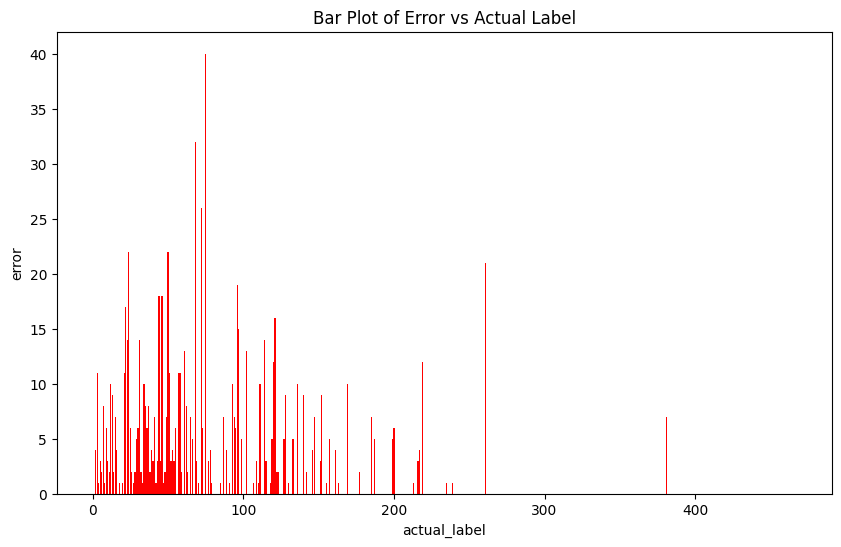

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(merged_df['label_gold'], merged_df['diff'], color='red')
plt.xlabel('actual_label')
plt.ylabel('error')
plt.title('Bar Plot of Error vs Actual Label')
plt.show()

In [ ]:
merged_df['text_len'] = merged_df['text'].str.len()
merged_df['text_words'] = merged_df['text'].str.split().str.len()

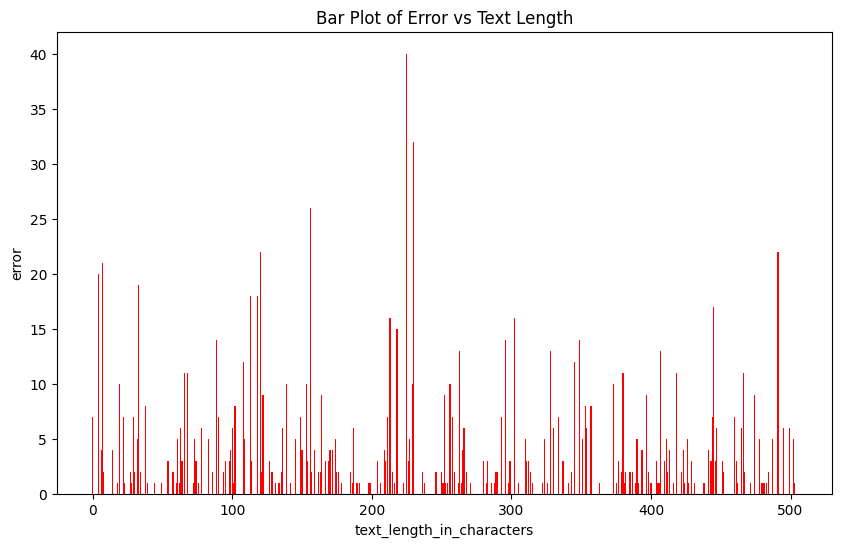

In [ ]:
sorted2_df = merged_df.sort_values(by='text_len', ascending=True)
plt.figure(figsize=(10, 6))
plt.bar(sorted2_df.index, sorted2_df['diff'], color='red')
plt.xlabel('text_length_in_characters')
plt.ylabel('error')
plt.title('Bar Plot of Error vs Text Length')
plt.show()

<ipython-input-54-9a7916cb9f29>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['diff'], color='purple', shade=True)


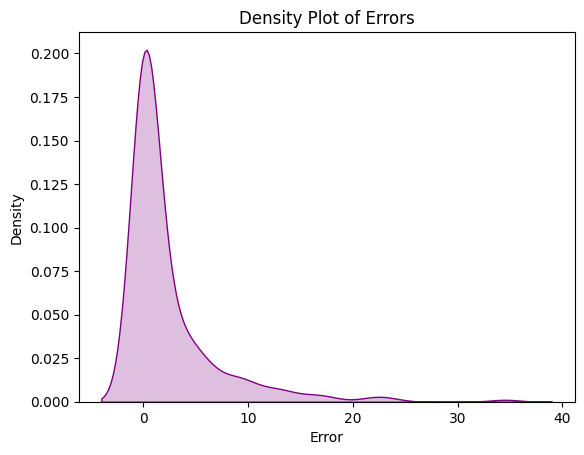

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(merged_df['diff'], color='purple', shade=True)
plt.xlabel('Error')
plt.title('Density Plot of Errors')
plt.show()